# Anomaly detection with Autoencoder

In [0]:
# !curl -s https://course.fast.ai/setup/colab | bash

Updating fastai...
Done.


In [0]:
# from google.colab import drive
# drive.mount('/content/gdrive', force_remount=True)
# root_dir = "/content/gdrive/My Drive/"
# base_dir = root_dir + 'dashlink/'

In [0]:
from fastai.vision import *
import torchvision
import torchvision.transforms as T
from torchvision import datasets
import torch
# from skimage.color import rgba2rgb, rgb2gray

In [0]:
# path = Path('Tail_687_1/png1'); path
trnpath = Path(base_dir + 'Tail_687_1'); trnpath

PosixPath('/content/gdrive/My Drive/dashlink/Tail_687_1')

In [0]:
# set output folder
# outpath = Path('png4a'); outpath

In [0]:
# path.ls()
# ! ls -alh "{trnpath}"/{outpath}

## Data

---



In [0]:
# #images from PIL are 4 channels
# from PIL import Image

# data_dir = trnpath/'png4'/'non'
# filenames = os.listdir(data_dir); filenames
# filenames = os.path.join(data_dir, '687200107051019-1min.png')
# image = Image.open(filenames)  # PIL image
# print(type(image))
# image

In [0]:
# npa = np.array(image); (npa).shape

In [0]:
#https://cs230-stanford.github.io/pytorch-vision.html
from PIL import Image
import PIL.ImageOps
from torch.utils.data import Dataset, DataLoader

class AutoencoderDataset(Dataset):
  def __init__(self, data_dir, transform):      
    # store filenames
    self.filenames = os.listdir(data_dir)
    self.filenames = [os.path.join(data_dir, f) for f in self.filenames] 
    self.transform = transform
      
  def __len__(self):
    # return size of dataset
    return len(self.filenames)
      
  def __getitem__(self, idx):
    # open image, convert from 4 to 3 channels, apply transforms, and return
  
    png = Image.open(self.filenames[idx])
    
    #https://stackoverflow.com/questions/9166400/convert-rgba-png-to-rgb-with-pil
#     png.load() # required for png.split()
#     background = Image.new("RGB", png.size, (255, 255, 255))
#     background.paste(png, mask=png.split()[3]) # 3 is the alpha channel
#     out = background

    r,g,b,a = png.split()
    rgb_img = Image.merge('RGB', (r,g,b))
    out = rgb_img
    
    ##png = rgba2rgb(png)
    ##out = rgb2gray(out)
    
    out = out.convert('L') #Luminosity, only 1 channel
    out = PIL.ImageOps.invert(out) #invert
    
    out = self.transform(out)
    return np.array(out)

In [0]:
bs = 8
# bs = 16
# bs = 32

### Create Tentative Dataset

In [0]:
#typpath = Path('typ')
##traindir = trnpath/outpath/typpath; traindir
# traindir = trnpath/outpath; traindir

In [0]:
#Compose means applied in a sequence
# train_transform = T.Compose([T.Resize([130,130]), T.ToTensor(), T.Normalize(pop_mean, pop_std)])
# tent_transform = T.Compose([T.Resize([130,130]), T.ToTensor()])
tent_transform = T.Compose([T.Resize([128,128]), T.ToTensor()])

In [0]:
# tent_dataset = datasets.ImageFolder(str(traindir), tent_transform)
tent_dataset = AutoencoderDataset(str(trnpath/'png4a'/'typ'), tent_transform)
len(tent_dataset)

474

In [0]:
print(tent_dataset[0].shape)
print(type(tent_dataset[0]))

(1, 128, 128)
<class 'numpy.ndarray'>


### Create Tentative DataLoader

In [0]:
tent_loader =  torch.utils.data.DataLoader(tent_dataset, batch_size=bs, shuffle=True, num_workers=2)

In [0]:
len(tent_loader.dataset)

474

### Normalize data

In [0]:
# for i in range(len(il)):
#   if(i==2): break
#   numpy_image = il[i].data.cpu().data.numpy(); print(numpy_image)
#   #numpy_image = xb[0].cpu().data.numpy(); print(numpy_image)
# #   batch_mean = np.mean(numpy_image, axis=(0,2,3))
# #   batch_std = np.std(numpy_image, axis=(0,2,3))

# il[0].data

# xb,yb = iter(data.train_dl.dl).next()
# print(f'len(xb[1]): {len(xb[1])}')
# # print(f'type(xb[0]): {type(xb[0])}')
# # xb[0]

#### Experiment with one batch of toy data

In [0]:
# ib = torch.tensor([[[[1,1],
#                      [1,1],
#                      [1,1]],
#                     [[2,2],
#                      [2,2],
#                      [2,2]],
#                     [[3,3],
#                      [3,3],
#                      [3,3]]],
#                    [[[4,4],
#                      [4,4],
#                      [4,4]],
#                     [[5,5],
#                      [5,5],
#                      [5,5]],
#                     [[6,6],
#                      [6,6],
#                      [6,6]]]]); ib

In [0]:
# numpy_ib = ib.cpu().data.numpy()
# np.sum(numpy_ib, axis=(0,2,3), keepdims=True)

#### Experiment with one batch of real data

In [0]:
xb = iter(tent_loader).next()
xb_np = xb.cpu().data.numpy(); print(xb_np.shape)
#xb_np_mean = np.mean(xb_np, axis=(0,2,3), keepdims=True); print(xb_np_mean.shape)
xb_np_mean = np.mean(xb_np, axis=(0,2,3)); print(xb_np_mean.shape)
xb_np_std = np.std(xb_np, axis=(0,2,3)); print(xb_np_std.shape)
xb_np_mean,xb_np_std

(8, 1, 128, 128)
(1,)
(1,)


(array([0.076384], dtype=float32), array([0.248902], dtype=float32))

#### Normalize the real data

In [0]:
pop_mean = []
pop_std = []
for xb in tent_loader:
  xb_np = xb.cpu().data.numpy(); #print(xb_np.shape)
  xb_np_mean = np.mean(xb_np, axis=(0,2,3)); #print(xb_np_mean.shape)
  xb_np_std = np.std(xb_np, axis=(0,2,3)); #print(xb_np_std.shape)
  pop_mean.append(xb_np_mean)
  pop_std.append(xb_np_std)
pop_mean = np.array(pop_mean)
pop_std = np.array(pop_std)

pop_mean = pop_mean.mean(axis=0)
pop_std = pop_std.mean(axis=0)
print(pop_mean, pop_std)

[0.075804] [0.24789]


In [0]:
print(pop_mean, pop_std)

[0.075804] [0.24789]


### Create Datasets

In [0]:
# import torchvision.transforms as T
# from torchvision import datasets

In [0]:
#Compose means applied in a sequence
# train_transform = T.Compose([T.Resize([128,128]), T.ToTensor(), T.Normalize(pop_mean, pop_std)])
train_transform_wo_norm = T.Compose([T.Resize([128,128]), T.ToTensor()])

In [0]:
# dataset = datasets.ImageFolder(str(traindir), train_transform)
# dataset.classes

In [0]:
# norm_dataset = AutoencoderDataset(str(trnpath/'png4a'/'typ'), train_transform)
norm_dataset = AutoencoderDataset(str(trnpath/'png4a'/'typ'), train_transform_wo_norm)
len(norm_dataset)

474

In [0]:
norm_dataset[0].shape

(1, 128, 128)

In [0]:
# anom_dataset = AutoencoderDataset(str(trnpath/'png4a'/'non'), train_transform)
anom_dataset = AutoencoderDataset(str(trnpath/'png4a'/'non'), train_transform_wo_norm)
len(anom_dataset)

81

In [0]:
anom_dataset[0].shape

(1, 128, 128)

### Create DataLoaders

In [0]:
norm_loader = torch.utils.data.DataLoader(norm_dataset, batch_size=bs, shuffle=True)

In [0]:
anom_loader = torch.utils.data.DataLoader(anom_dataset, batch_size=bs, shuffle=True)

### Show a batch of normal images

In [0]:
xb = iter(norm_loader).next()

xb.shape

torch.Size([8, 1, 128, 128])

In [0]:
xb[0].shape

torch.Size([1, 128, 128])

In [0]:
images = torchvision.utils.make_grid(xb)
images.shape

torch.Size([3, 132, 1042])

In [0]:
images = np.transpose(images, (1,2,0))
images.shape

torch.Size([132, 1042, 3])

In [0]:
m,M = images.min(),images.max()
m,M

(tensor(0.), tensor(1.))

In [0]:
images_sc = (1/(abs(m)*M))*images + 0.5 #scale the normalized image to the range 0,1
len(images_sc)

132

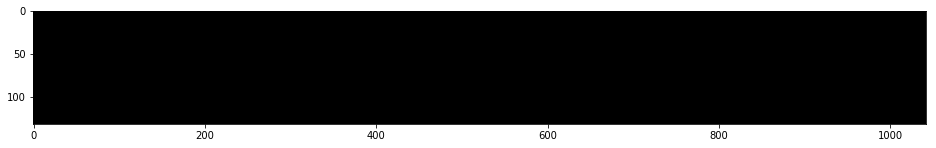

In [0]:
plt.figure(figsize=(16,12))
plt.imshow(images_sc)
plt.show()

### Show a batch of anomalous images

In [0]:
xb = iter(anom_loader).next()

xb.shape

torch.Size([8, 1, 128, 128])

In [0]:
xb[0].shape

torch.Size([1, 128, 128])

In [0]:
images = torchvision.utils.make_grid(xb)
images.shape

torch.Size([3, 132, 1042])

In [0]:
images = np.transpose(images, (1,2,0))
images.shape

torch.Size([132, 1042, 3])

In [0]:
m,M = images.min(),images.max()
m,M

(tensor(0.), tensor(1.))

In [0]:
images_sc = (1/(abs(m)*M))*images + 0.5 #scale the normalized image to the range 0,1
len(images_sc)

132

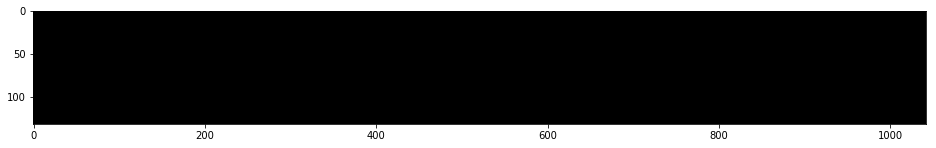

In [0]:
plt.figure(figsize=(16,12))
plt.imshow(images_sc)
plt.show()

## Model

In [0]:
class LinearAutoencoder(nn.Module):
  def __init__(self, encoding_dim):
    super(LinearAutoencoder, self).__init__()
    #encoder
    self.fc1e = nn.Linear(1*128*128, encoding_dim)
    #self.fc2e = nn.Linear(1024, encoding_dim)

    #decoder
    #self.fc2d = nn.Linear(encoding_dim, 1024)
    self.fc1d = nn.Linear(encoding_dim, 1*128*128)
    
  def forward(self, x):
    x = F.relu(self.fc1e(x))
    #x = F.relu(self.fc2e(x))
    
    #x = F.relu(self.fc2d(x))
    x = torch.sigmoid(self.fc1d(x)) #scaling from 0 to 1
    return x

In [0]:
class ConvAutoencoder(nn.Module):
  def __init__(self):
    super(ConvAutoencoder, self).__init__()
    #input signal: 3 x 32 x 32
    #self.conv1e = nn.Conv2d(  3,  24, 3, padding=2) #24 x 30 x 30
    self.conv1e = nn.Conv2d(  1,  24, 3, padding=2) #24 x 30 x 30
    self.conv2e = nn.Conv2d( 24,  48, 3, padding=2) #48 x 28 x 28
    self.conv3e = nn.Conv2d( 48,  96, 3, padding=2) #96 x 26 x 26
    self.conv4e = nn.Conv2d( 96, 128, 3, padding=2) #128 x 24 x 24
    self.conv5e = nn.Conv2d(128, 256, 3, padding=2) #256 x 22 x 22
    self.mp1e   = nn.MaxPool2d(2, return_indices=True) #256 x 11 x 11

    self.mp1d   = nn.MaxUnpool2d(2)
    self.conv5d = nn.ConvTranspose2d(256, 128, 3, padding=2)
    self.conv4d = nn.ConvTranspose2d(128,  96, 3, padding=2)
    self.conv3d = nn.ConvTranspose2d( 96,  48, 3, padding=2)
    self.conv2d = nn.ConvTranspose2d( 48,  24, 3, padding=2)
    #self.conv1d = nn.ConvTranspose2d( 24,   3, 3, padding=2)
    self.conv1d = nn.ConvTranspose2d( 24,   1, 3, padding=2)
    
  def forward(self, x):
    #Encoder
    x = F.relu(self.conv1e(x))
    x = F.relu(self.conv2e(x))
    x = F.relu(self.conv3e(x))
    x = F.relu(self.conv4e(x))
    x = F.relu(self.conv5e(x))
    x,i = self.mp1e(x)
    #Decoder
    x = self.mp1d(x, i)
    x = F.relu(self.conv5d(x))
    x = F.relu(self.conv4d(x))
    x = F.relu(self.conv3d(x))
    x = F.relu(self.conv2d(x))
    x = F.relu(self.conv1d(x))    
    return x

In [0]:
class ConvAutoencoder2(nn.Module):
  def __init__(self):
    super(ConvAutoencoder2, self).__init__()
    #encoder
    self.conv1 = nn.Conv2d(1, 32, 3, padding=1)
    self.conv2 = nn.Conv2d(32, 8, 3, padding=1)
    self.pool = nn.MaxPool2d(2, 2)    
    #decoder
    self.t_conv1 = nn.ConvTranspose2d(8, 32, 2, stride=2)
    self.t_conv2 = nn.ConvTranspose2d(32, 1, 2, stride=2)
    
  def forward(self, x):
    #Encoder
    x = F.relu(self.conv1(x))
    x = self.pool(x)
    x = F.relu(self.conv2(x))
    x = self.pool(x)
    #Decoder
    x = F.relu(self.t_conv1(x))
    x = torch.sigmoid(self.t_conv2(x))
    return x

In [0]:
# learning_rate = 1e-3 #.973
# learning_rate = 2e-3 #
learning_rate = 3e-3 #
# learning_rate = 5e-3 #
# learning_rate = 1e-2 #

In [0]:
# device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
# print(device)

In [0]:
# autoencoder = LinearAutoencoder(16).cuda() #.91
# autoencoder = LinearAutoencoder(24).cuda() #.89
# autoencoder = LinearAutoencoder(28).cuda() #.86
# autoencoder = LinearAutoencoder(32).cuda() #.88
# autoencoder = LinearAutoencoder(36).cuda() #.88
# autoencoder = LinearAutoencoder(40).cuda() #.89
# autoencoder = LinearAutoencoder(44).cuda() #.87
# autoencoder = LinearAutoencoder(48).cuda() #.87
# autoencoder = LinearAutoencoder(52).cuda() #.86
# autoencoder = LinearAutoencoder(56).cuda() #.86
# autoencoder = LinearAutoencoder(60).cuda() #.855
# autoencoder = LinearAutoencoder(64).cuda() #.84
# autoencoder = LinearAutoencoder(68).cuda() #.85
# autoencoder = LinearAutoencoder(72).cuda() #.84
# autoencoder = LinearAutoencoder(76).cuda() #.85
# autoencoder = LinearAutoencoder(80).cuda() #.84
# autoencoder = LinearAutoencoder(84).cuda() #.85
# autoencoder = LinearAutoencoder(88).cuda() #.84
# autoencoder = LinearAutoencoder(92).cuda() #.84
# autoencoder = LinearAutoencoder(96).cuda() #.84
# autoencoder = LinearAutoencoder(100).cuda() #.84
# autoencoder = LinearAutoencoder(104).cuda() #.84
# autoencoder = LinearAutoencoder(108).cuda() #.84
# autoencoder = LinearAutoencoder(112).cuda() #.84
# autoencoder = LinearAutoencoder(116).cuda() #.84
# autoencoder = LinearAutoencoder(120).cuda() #.84
# autoencoder = LinearAutoencoder(124).cuda() #.84
# autoencoder = LinearAutoencoder(128).cuda() #.84
# autoencoder = LinearAutoencoder(136).cuda() #.84
# autoencoder = LinearAutoencoder(142).cuda() #.83
autoencoder = LinearAutoencoder(150).cuda() #.82
# autoencoder = LinearAutoencoder(158).cuda() #.83
# autoencoder = LinearAutoencoder(166).cuda() #.83
# autoencoder = LinearAutoencoder(174).cuda() #.83
# autoencoder = LinearAutoencoder(182).cuda() #.82
# autoencoder = LinearAutoencoder(190).cuda() #.84
# autoencoder = LinearAutoencoder(198).cuda() #.83

# autoencoder = LinearAutoencoder(228).cuda() #.82
# autoencoder = LinearAutoencoder(256).cuda() #.83
# autoencoder = LinearAutoencoder(512).cuda() #.82
# autoencoder = LinearAutoencoder(1024).cuda() #.87

# autoencoder = ConvAutoencoder().cuda()
# autoencoder = ConvAutoencoder2().cuda()
print(autoencoder)

LinearAutoencoder(
  (fc1e): Linear(in_features=16384, out_features=150, bias=True)
  (fc1d): Linear(in_features=150, out_features=16384, bias=True)
)


In [0]:
# parameters = list(autoencoder.parameters())
loss_func = nn.MSELoss()
optimizer = torch.optim.Adam(autoencoder.parameters(), lr=learning_rate)

## Train on normal images

In [0]:
# #def show_img(orig, noisy, denoised):
# def show_img(orig, reconstructed):
#     fig=plt.figure()
    
#     orig = orig.swapaxes(0, 1).swapaxes(1, 2)
#     ##noisy = noisy.swapaxes(0, 1).swapaxes(1, 2)
#     reconstructed = reconstructed.swapaxes(0, 1).swapaxes(1, 2)
    
#     # Normalize for display purpose
#     orig     = (orig - orig.min()) / (orig.max() - orig.min())
#     ##noisy    = (noisy - noisy.min()) / (noisy.max() - noisy.min())
#     reconstructed = (reconstructed - reconstructed.min()) / (reconstructed.max() - reconstructed.min())
    
#     fig.add_subplot(1, 3, 1, title='Original')
#     plt.imshow(orig)
    
#     fig.add_subplot(1, 3, 3, title='Reconstructed')
#     plt.imshow(reconstructed)
    
#     fig.subplots_adjust(wspace = 0.5)
#     plt.show()
    
# # To test
# # show_img(cifar10_train[0][0].numpy(), cifar10_train[1][0].numpy(), cifar10_train[2][0].numpy())

In [0]:
xb = iter(norm_loader).next(); print(xb.shape, xb.size(0))
xb = xb.view(xb.size(0), -1); print(xb.shape)

torch.Size([8, 1, 128, 128]) 8
torch.Size([8, 16384])


In [0]:
# type(xb)
# xb = xb.type('torch.FloatTensor')
xb = xb.cuda()
yhb = autoencoder(xb); print(yhb.shape, type(yhb))
# orig = xb[0].cpu()
# reconstructed = yhb[0].cpu()
# show_img(orig.data.numpy(), reconstructed.data.numpy())

torch.Size([8, 16384]) <class 'torch.Tensor'>


In [0]:
# orig = xb[0].view(130, 130, 1).cpu(); print(orig.shape)
# orig.data.numpy

In [0]:
# show_img(orig.data.numpy(), orig.data.numpy())

In [0]:
epochs = 200
# train_loss = []
# valid_loss = []
for epoch in range(1, epochs+1):
#     if(epoch==2): break

    # Let's train the model
    #total_trn_loss = 0.0
    #total_trn_iter = 0
    train_loss = 0.0
    autoencoder.train()
    for i,xb in enumerate(norm_loader):
        xb = xb.view(xb.size(0), -1) #for 1D to flatten image into vector
        xb = xb.cuda()
        optimizer.zero_grad()
        yhb = autoencoder(xb)
        
        loss = loss_func(yhb, xb)
        loss.backward()
        optimizer.step()
        
        #total_trn_iter += 1
        #total_trn_loss += loss.item()
        #train_loss += loss.item()*xb.size(0)
        train_loss += loss.item()
        #print('Batch: {} \ttrain_loss: {:.6f}'.format(i, loss.item()))
    #print avg train stats
    #train_loss = train_loss/len(norm_loader)
    print('----Epoch: {} \tavg train_loss: {:.6f}'.format(epoch, train_loss/(i+1)))
    
#     # Let's record the validation loss
#     #total_val_loss = 0.0
#     #total_val_iter = 0
#     autoencoder.eval()
# #     for xb, yb in valid_loader:
#     for xb in norm_loader:
#         xb = xb.view(xb.size(0), -1) #for 1D to flatten image into vector
#         xb = xb.cuda()
#         yhb = autoencoder(xb)
#         loss = loss_func(yhb, xb)
        
#         total_val_iter += 1
#         total_val_loss += loss.item()
        
#     # Let's visualize the first image of the last batch in our validation set
#     orig = xb[0].cpu()
# #     orig = xb[0].view(130, 130, 1).cpu()
#     reconstructed = yhb[0].cpu()
# #     reconstructed = yhb[0].view(130, 130, 1).cpu()

#     print("... after Epoch", epoch)
#     show_img(orig.data.numpy(), reconstructed.data.numpy())
    
#     train_loss.append(total_trn_loss / total_trn_iter)
#     valid_loss.append(total_val_loss / total_val_iter)
#     print(f'train_loss: {train_loss[-1]},    valid_loss: {valid_loss[-1]}')

----Epoch: 1 	avg train_loss: 0.064300
----Epoch: 2 	avg train_loss: 0.038408
----Epoch: 3 	avg train_loss: 0.025167
----Epoch: 4 	avg train_loss: 0.018549
----Epoch: 5 	avg train_loss: 0.015153
----Epoch: 6 	avg train_loss: 0.012409
----Epoch: 7 	avg train_loss: 0.010713
----Epoch: 8 	avg train_loss: 0.009928
----Epoch: 9 	avg train_loss: 0.009125
----Epoch: 10 	avg train_loss: 0.008625
----Epoch: 11 	avg train_loss: 0.008060
----Epoch: 12 	avg train_loss: 0.007106
----Epoch: 13 	avg train_loss: 0.006585
----Epoch: 14 	avg train_loss: 0.006388
----Epoch: 15 	avg train_loss: 0.006142
----Epoch: 16 	avg train_loss: 0.005926
----Epoch: 17 	avg train_loss: 0.005640
----Epoch: 18 	avg train_loss: 0.005454
----Epoch: 19 	avg train_loss: 0.005314
----Epoch: 20 	avg train_loss: 0.005242
----Epoch: 21 	avg train_loss: 0.005268
----Epoch: 22 	avg train_loss: 0.005122
----Epoch: 23 	avg train_loss: 0.004943
----Epoch: 24 	avg train_loss: 0.004991
----Epoch: 25 	avg train_loss: 0.004934
----Epoch

In [0]:
# save model
# torch.save(autoencoder.state_dict(), "./5.autoencoder.pth")

In [0]:
# fig = plt.figure(figsize=(10, 7))
# plt.plot(train_loss[1:], label='Train loss')
# plt.plot(valid_loss[1:], label='Validation loss')
# plt.legend()
# plt.show()

## Check normal images

torch.Size([8, 1, 128, 128])
torch.Size([8, 16384])
torch.Size([8, 16384])
torch.Size([8, 1, 128, 128])
(8, 1, 128, 128)
(8, 1, 128, 128)


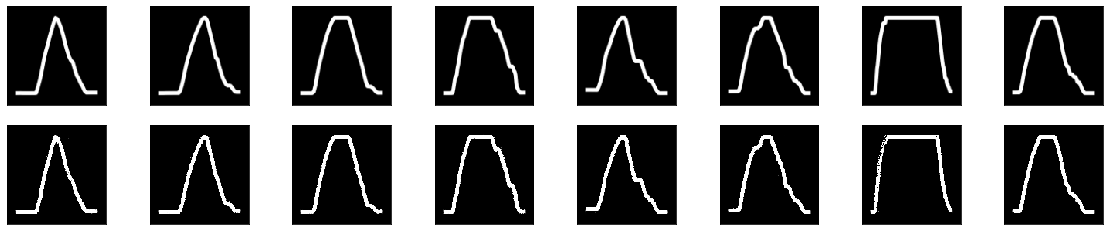

In [0]:
X = iter(norm_loader).next(); print(X.shape)
# X = X[0].unsqueeze(0); print(X.shape)
X_flat = X.view(X.size(0), -1); print(X_flat.shape)
Yh_flat = autoencoder(X_flat.cuda()); print(Yh_flat.shape)
Yh = Yh_flat.view(X.size(0), 1, 128, 128); print(Yh.shape)

# Yh = autoencoder(X.cuda()); print(Yh.shape)

#prepare for visualization
X_vis = X.numpy(); print(X_vis.shape)
Yh_vis = Yh.detach().cpu().numpy(); print(Yh_vis.shape)
#visualize; originals in top row, reconstructions in bottom row
fig,axes = plt.subplots(nrows=2, ncols=8, sharex=True, sharey=True, figsize=(20,4))
for X_vis,row in zip([X_vis, Yh_vis], axes):
  for img,ax in zip(X_vis, row):
    ax.imshow(np.squeeze(img), cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)    

## Check anomalous images



In [0]:
# epochs = 10
# for epoch in range(1, epochs+1):
#     if(epoch==2): break   
#     valid_loss = 0.0
    autoencoder.eval()
    for i,xb in enumerate(anom_loader):
        xb = xb.view(xb.size(0), -1) #for 1D to flatten image into vector
        xb = xb.cuda()
        yhb = autoencoder(xb)
        loss = loss_func(yhb, xb)
        ##valid_loss += loss.item()*xb.size(0)
        print('Batch: {} \tvalid_loss: {:.6f}'.format(i, loss.item()))
#     #print avg valid stats      
#     valid_loss = valid_loss/len(anom_loader)
#     print('Epoch: {} \tvalid_loss: {:.6f}'.format(epoch, valid_loss))

Batch: 0 	valid_loss: 0.066135
Batch: 1 	valid_loss: 0.051040
Batch: 2 	valid_loss: 0.062726
Batch: 3 	valid_loss: 0.050727
Batch: 4 	valid_loss: 0.047579
Batch: 5 	valid_loss: 0.048365
Batch: 6 	valid_loss: 0.060757
Batch: 7 	valid_loss: 0.049715
Batch: 8 	valid_loss: 0.057604
Batch: 9 	valid_loss: 0.060311
Batch: 10 	valid_loss: 0.091372


In [0]:
# # type(xb)
# # xb = xb.type('torch.FloatTensor')
# yhb = autoencoder(xb.cuda())
# # type(yhb)

# orig = xb[0].cpu()
# reconstructed = yhb[0].cpu()
# show_img(orig.data.numpy(), reconstructed.data.numpy())

In [0]:
# epochs = 20
# train_loss = []
# valid_loss = []
# Let's record the validation loss
total_val_loss = 0.0
total_val_iter = 0
#autoencoder = autoencoder.cpu()
autoencoder.eval()
#for xb, yb in data.valid_dl:  
#     for xb, yb in valid_loader:
for i, xb in enumerate(anom_loader):
#     xb = np.transpose(xb, (0, 3, 1, 2))
#     xb = xb.type('torch.FloatTensor')
    xb = xb.cuda()
    yhb = autoencoder(xb)
    loss = loss_func(yhb, xb)

    #total_val_iter += 1
    #total_val_loss += loss.item()

    # Let's visualize the first image of the last batch in our validation set
    orig = xb[0].cpu()
    reconstructed = yhb[0].cpu()

    print("... after batch", i)
    show_img(orig.data.numpy(), reconstructed.data.numpy())
# train_loss.append(total_trn_loss / total_trn_iter)
# valid_loss.append(total_val_loss / total_val_iter)
    print(f'valid_loss: {loss.item()}')

... after batch 0


NameError: ignored